# Titanic dataset - exploratory data analysis and modelling

*James Thomas*  
*8th May 2020*

## The big picture

The task is to predict whether a passenger on the Titanic survived or died in the disaster of 15 April 1912.

The data includes various information for each passenger and (in the case of the training set) labels defining the outcome for that passenger.

This will be a supervised classification problem. Since this is a training exercise, there is no existing system and the object is to get as high a performing model as possible. The metric used to evaluate the model will be categorisation accuracy.

## Get the data

The dataset is freely available and is provided by Kaggle as separate training and test datasets, in `csv` format.

The training set contains lables but that set does not.

They can be downloaded from Kaggle website or via the API:

    $ kaggle competitions download titanic

They should be downloaded and unzippsed inside the ../raw_data/ folder.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.simplefilter("always")

# Pandas and plotting defaults
pd.set_option("max_colwidth", None)
plt.rc("axes.spines", top=False, right=False)
sns.set_palette("colorblind")

# Reproducible analyses
np.random.seed(1234)

%load_ext autoreload
%autoreload 2

# Convenience functions to add data lables to plots
from utils import add_totals, add_rates

## Load the data

In [2]:
train = pd.read_csv("../raw_data/train.csv", index_col=0)
test = pd.read_csv("../raw_data/test.csv", index_col=0)

## Explore the data

Summary of data exploration steps:

1. Features
    * What is known about the feature?
    * What is the datatype?
    * What is the distribution of values?
    * Is it (or could it be) categorical? (if so, what encoding might be appropriate?)
    * How many unique values are there? (# and % of total)
        - Even if there are many unique values, is there any useful information that could be extracted? (e.g. title from name)
    * How many values are present or missing? (# and % of total)
        - Should these be imputed or dropped?
        - How should they be imputed? e.g. missing value, median, most, by correlation with other features
        - Should an indicator column be used to denote imputed values?
    * Does the data need to be cleaned?
        - Is the data noisy?
        - Are there rounding errors?
        - Are there outliers?
    * Are the statistics observed in the training data also observed in the test data?


2. Target
    * What is the % survival rate? (for a baseline prediction score)
    * How does a simple linear model using the highest correlating feature perform? (a better baseline score)


3. Relationship between features/target
    * Which features have the highest correlations with the target variable?
    * What is the correlation between pairs of features?
    * Are there any clusters? (using an unsupervised approach)
    * How might the problem be solved manually? 


4. Feature engineering
    * What transformations could be applied to existing features?
    * What features could be derived from the existing features? e.g.
        - family size from siblings + children/parents
        - is passenger alone? (see ticket number)
        - is passenger a parent?
        - is passenger a mother?
    * What can be extracted from string fields? e.g.
        - title from name
        - deck from cabin
    * Can continuous variables be grouped into bins? (an ordinal categorical feature)
        - especially if they are not 100% certain, e.g. fare or age
        - or where this might be useful, e.g. adult/child from age


5. Additional data
    * Could more data be gathered?
    * Could extra features be gathered?

### Take a look

Look at a random selection of the training data:

In [3]:
train.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,B18,C
779,0,3,"Kilgannon, Mr. Thomas J",male,NaN,0,0,36865,7.7375,NaN,Q
761,0,3,"Garfirth, Mr. John",male,NaN,0,0,358585,14.5000,NaN,S
497,1,1,"Eustis, Miss. Elizabeth Mussey",female,54.0,1,0,36947,78.2667,D20,C
584,0,1,"Ross, Mr. John Hugo",male,36.0,0,0,13049,40.1250,A10,C
41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,NaN,S
783,0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S
241,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C
147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S


### Understand each feature

Check the column datatypes, number of null values, and of unique values:

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
train.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

There are 4 integer columns:
 * `Survived` is the _target_ and is a _binary variable_. `1` = survived and `0` = died.
 * `Pclass` is the passenger class and is a _categorical variable_. The classes are `1` = first, `2` = second, `3` = third class.
 * `SibSp` is the number of siblings or spouses on board and is a _discrete variable_.
 * `Parch` is the number of parents or children on board and is also a _discrete variable_.
 
2 float columns:
 * `Age` is the age of the passenger in years. It is technically a _continuous variable_ as some rows have non-integer numbers of years, however many are rounded to the nearest year. There are 177 rows with missing values.
 * `Fare` is the fare price of the ticket and is a _continuous variable_.

and 5 string columns:
 * `Name` is the name of the passenger.
 * `Sex` is the sex of the passenger and is a _categorical variable_.
 * `Ticket` is the ticket number (which is a string because it may contain letters).
 * `Cabin` is the cabin number of the passenger, which includes the deck. However the majority of the cabin numbers are missing.
 * `Embarked` is the port of embarkation of the passenger and is a _categorical variable_, with just two missing values. The classes are `C` = Cherbourg, `Q` = Queenstown, `S` = Southampton.
 
The columns can therefore be divided into "numerical" types and "categorical" types, with three remaining "string" types.

In [6]:
numercial_types = ["Age", "Fare", "SibSp", "Parch"]
categorical_types = ["Pclass", "Sex", "Embarked"]
string_types = ["Name", "Ticket", "Cabin"]

### Distribution of numerical types

In [7]:
train[numercial_types].describe()

,Age,Fare,SibSp,Parch
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.523008,0.381594
std,14.526497,49.693429,1.102743,0.806057
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,0.000000
50%,28.000000,14.454200,0.000000,0.000000
75%,38.000000,31.000000,1.000000,0.000000
max,80.000000,512.329200,8.000000,6.000000


#### SibSp & Parch

The number of siblings/spouses and parents/children are highly skewed, and the majority of values are zero:

In [8]:
train["SibSp"].value_counts(sort=False)

0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64

In [9]:
train["Parch"].value_counts(sort=False)

0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parch, dtype: int64

#### Age & Fare

Age and fare have more complex distributions:

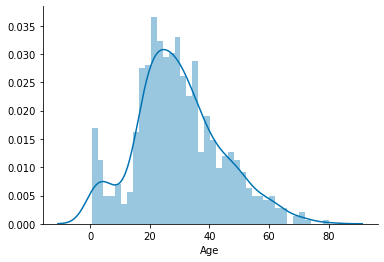

In [10]:
sns.distplot(train["Age"], bins=40);

Age is broadly normally distributed, with a longer right-hand tail and also a more babies and young children.

A quantile-quantile plot (QQ-plot) demonstates this visually:

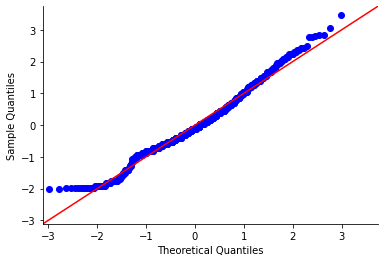

In [12]:
sm.qqplot(train["Age"].dropna(), fit=True, line="45");

On the other hand, fare is highly skewed and definitely not normally distributed:

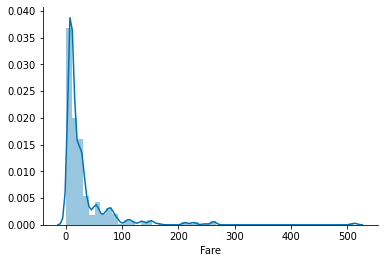

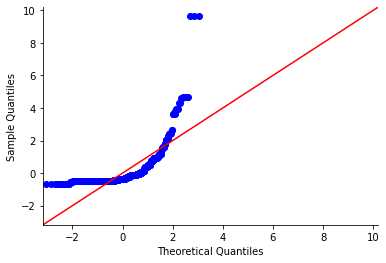

In [13]:
sns.distplot(train["Fare"])
sm.qqplot(train["Fare"], dist="norm", fit=True, line="45");

And there are 15 passengers with zero fare:

In [14]:
(train["Fare"] == 0).sum()

15

The distribution may be closer to a log-normal distribution:

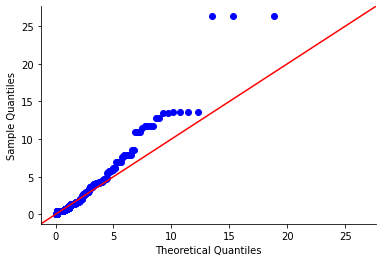

In [15]:
sm.qqplot(train["Fare"], dist="lognorm", fit=True, line="45");

So that the log of the fare is (somewhat) closer to a normal distribution:

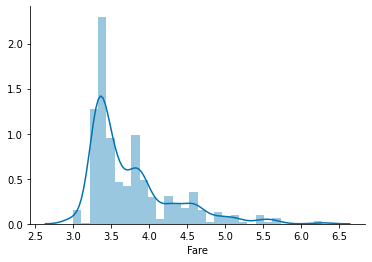

In [16]:
def transform_fare(fare, epsilon=20):
    """
    Apply a logarithmic transformation to fare.
    
    Args:
        epsilon: float >= 0
            Used to ensure there are no zeroes in the data
    """
    return np.log(fare + epsilon)
    
sns.distplot(
    transform_fare(train["Fare"]),
    bins=30,
);

### Distribution of categorical types

#### Pclass & Sex

Split the passengers by sex and ticket class:

In [17]:
train.groupby(["Pclass", "Sex"]).size().unstack()

Sex,female,male
Pclass,,
1,94,122
2,76,108
3,144,347


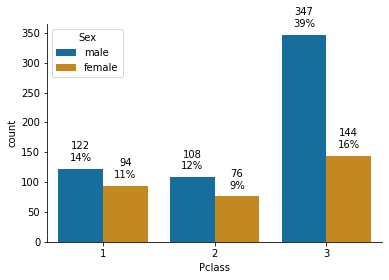

In [18]:
ax = sns.countplot(data=train, x="Pclass", hue="Sex")
add_totals(ax)

There were more men on board in all of the three passenger classes, although the difference is far more marked in third class, which also had the most passengers overall.

#### Embarked

Most of the passengers embarked in Southampton, then Cherbourg, then Queenstown (the order of calling-points on the route). Although the majority of passengers were in third class, the majority of passengers embarking at Cherbourg were in first class, and those embarking at Queenstown were nearly all in third class:

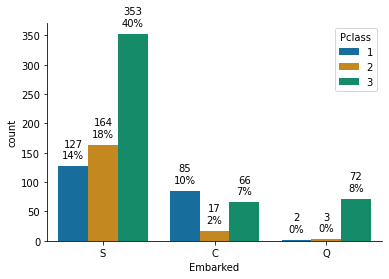

In [19]:
ax = sns.countplot(data=train, x="Embarked", hue="Pclass")
add_totals(ax)

### Compare with the target variable

Now look at the target variable (this is in the column `Survived`); check how many passengers survived in total:

In [20]:
train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

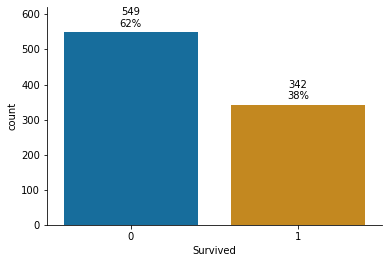

In [21]:
ax = sns.countplot(data=train, x="Survived")
ax.set_ylim(0, 620)
add_totals(ax)

Just over a third of the passengers survived, so there is a slight imbalance to the classes.

Was this the same across passenger class, sex and age?

#### Pclass

In [22]:
train.groupby(["Pclass", "Survived"]).size().unstack()

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


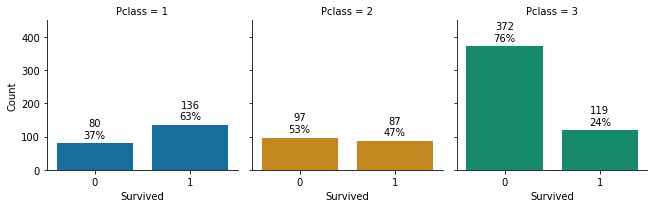

In [23]:
g = (
    sns.FacetGrid(train, col="Pclass", hue="Pclass")
    .map(sns.countplot, "Survived", order=(0, 1))
    .set_ylabels("Count")
    .set(ylim=(0, 450))
)
for ax in g.axes.flat:
    add_totals(ax)

In [24]:
train.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

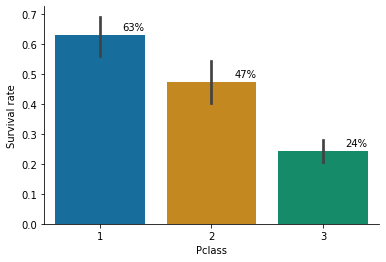

In [25]:
ax = sns.barplot(data=train, x="Pclass", y="Survived")
ax.set_ylabel("Survival rate")
add_rates(ax)

The bars show 95% confidence intervals, based on bootstrapping.

In first class almost two thirds of passengers survived. In second class there is roughly a 50:50 split.

Far more people died in third class, both in relative and aboslute terms (because most passengers were in that class) – so there is a marked difference.

#### Sex

In [26]:
train.groupby(["Sex", "Survived"]).size().unstack()

Survived,0,1
Sex,,
female,81,233
male,468,109


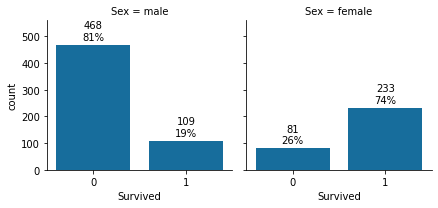

In [27]:
g = (
    sns.FacetGrid(train, col="Sex")
    .map(sns.countplot, "Survived", order=(0, 1))
    .set_ylabels("count")
    .set(ylim=(0, 560))
)
for ax in g.axes.flat:
    add_totals(ax)

In [28]:
train.groupby("Sex")["Survived"].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

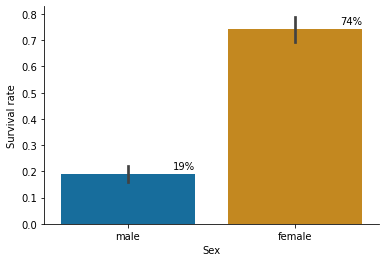

In [29]:
ax = sns.barplot(data=train, x="Sex", y="Survived")
ax.set_ylabel("Survival rate")        
add_rates(ax)

Far more women survived than men, so consider both passenger class and sex together.

#### Pclass & Sex

In [30]:
train.groupby(["Sex", "Pclass", "Survived"]).size().unstack()

Survived         0   1
Sex    Pclass         
female 1         3  91
       2         6  70
       3        72  72
male   1        77  45
       2        91  17
       3       300  47

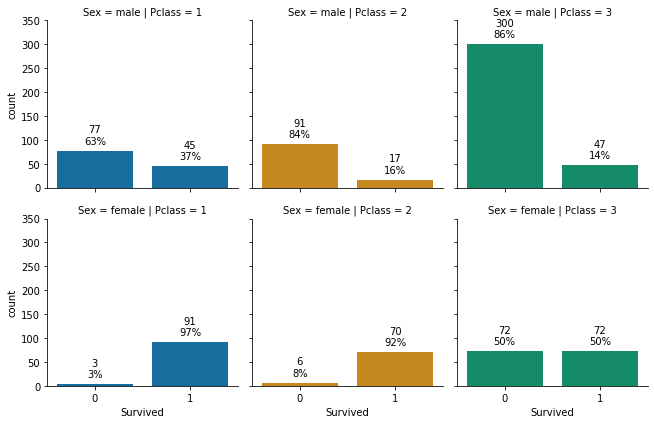

In [31]:
g = (
    sns.FacetGrid(train, col="Pclass", row="Sex", hue="Pclass")
    .map(sns.countplot, "Survived", order=(0, 1))
    .set_ylabels("count")
    .set(ylim=(0, 350))
)
for ax in g.axes.flat:
    add_totals(ax)

In [32]:
train.groupby(["Sex", "Pclass"])["Survived"].mean().unstack()

Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


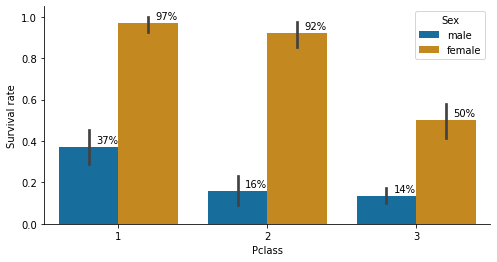

In [33]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=train, x="Pclass", y="Survived", hue="Sex")
ax.set_ylabel("Survival rate")        
add_rates(ax)

There are some huge differences – the majority of men in all the classes died – the survival rate in first class was 37%, however in second and third class (which were roughly the same) it was only around 15%.

Almost all women in first and second class survived, whereas only half of those in third class survived (there were more in this class, too).

These differences should be taken into account in any further analysis.

#### Age & Sex

Look at the distribution of ages of the passengers:

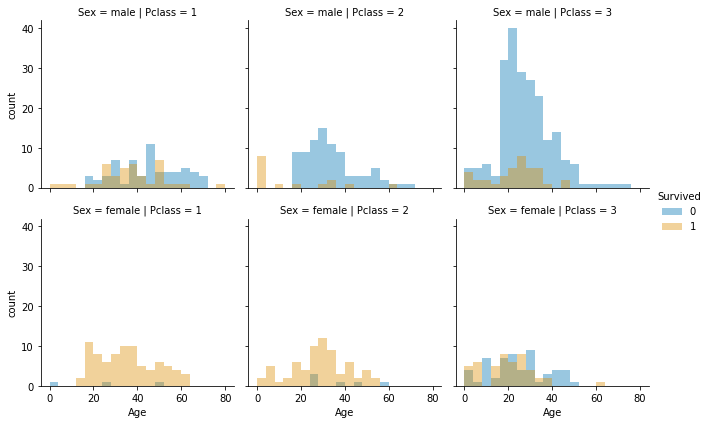

In [34]:
g = (
    sns.FacetGrid(train, col="Pclass", row="Sex", hue="Survived")
    .map(sns.distplot, "Age", kde=False, bins=range(0, 81, 4))
    .set_ylabels("count")
    .add_legend()
)

Most of the children (under 16) on board were in third class, followed by second class; there were fewest in first class. In first and second class, nearly all the children survived.

Of the older adults (over 60), there were more men than women on board, and the majority of these died.

Taking note of how many were in each age band, can see there were few older people in third (and to some extent, second) class. It therefore might be better to look at the percentage survival rate in groups.

#### AgeGroup

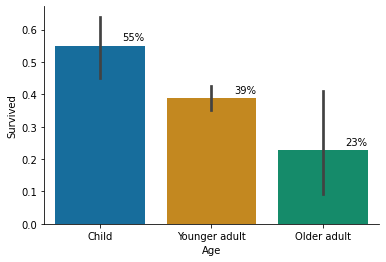

In [35]:
def get_age_group(df):
    return pd.cut(
        df["Age"], bins=[0, 16, 60, 100], labels=["Child", "Younger adult", "Older adult"]
    )

ax = sns.barplot(
    x=get_age_group(train),
    y=train["Survived"],
)
add_rates(ax)

#### AgeGroup, Pclass & Sex

Putting everything together, look at survival rate per age grouping, sex and passenger class:

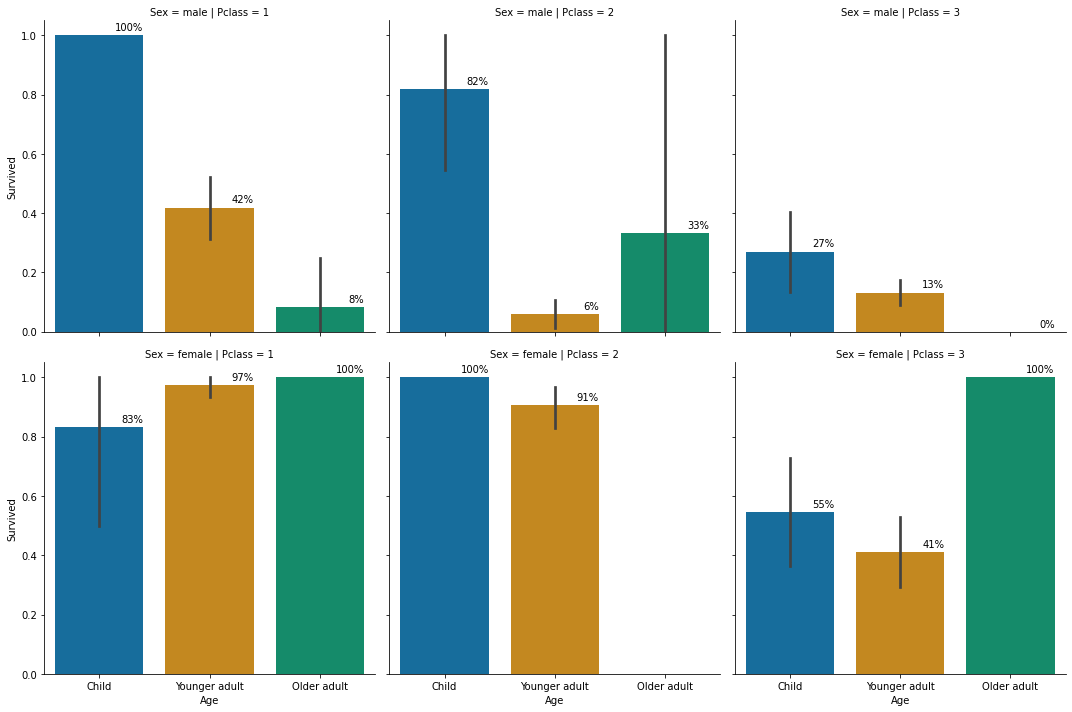

In [36]:
g = sns.catplot(
    data=train.assign(Age=get_age_group(train)),
    x="Age",
    y="Survived",
    col="Pclass",
    row="Sex",
    kind="bar",
    ci=95,
)
for ax in g.axes.flat:
    add_rates(ax)

### Feature engineering

From the cabin, it is possible to extract the deck by dropping the digits:

In [37]:
deck = train["Cabin"].str.replace("[^A-Z]", "")
deck.value_counts().sort_index()

A       15
B       36
BB       7
BBB      2
BBBB     2
C       51
CC       4
CCC      4
D       32
DD       1
E       32
F        9
FE       1
FG       3
G        4
T        1
Name: Cabin, dtype: int64

#### MultiCabins

Some passengers had multiple cabins (e.g. BB, CC, DD, etc.), although this does not appear to be that informative:

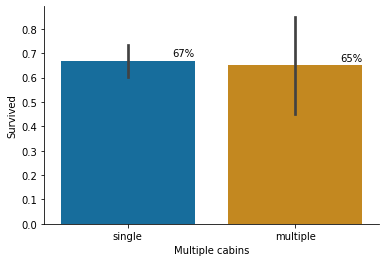

In [38]:
def get_multiple_cabins(df):
    deck = df["Cabin"].str.replace("[^A-Z]", "")
    multi_cabins = (deck.str.len() > 1) & ~(deck.isin(["FE", "FG"]))
    return np.select(
        [multi_cabins & deck.notna(), ~multi_cabins & deck.notna()],
        ["multiple", "single"],
        default=None,
    )

ax = sns.barplot(
    x=get_multiple_cabins(train),
    y=train["Survived"],
)
ax.set_xlabel("Multiple cabins")
add_rates(ax)

#### Deck 

FE and FG were separately accessed parts of F deck, and T deck is not a deck with cabins on.

Given that only just over 200 passengers in the training set have cabin information, and how few passengers there are in the lower decks, try assigning the lower decks (F, FE, FG and G) together:

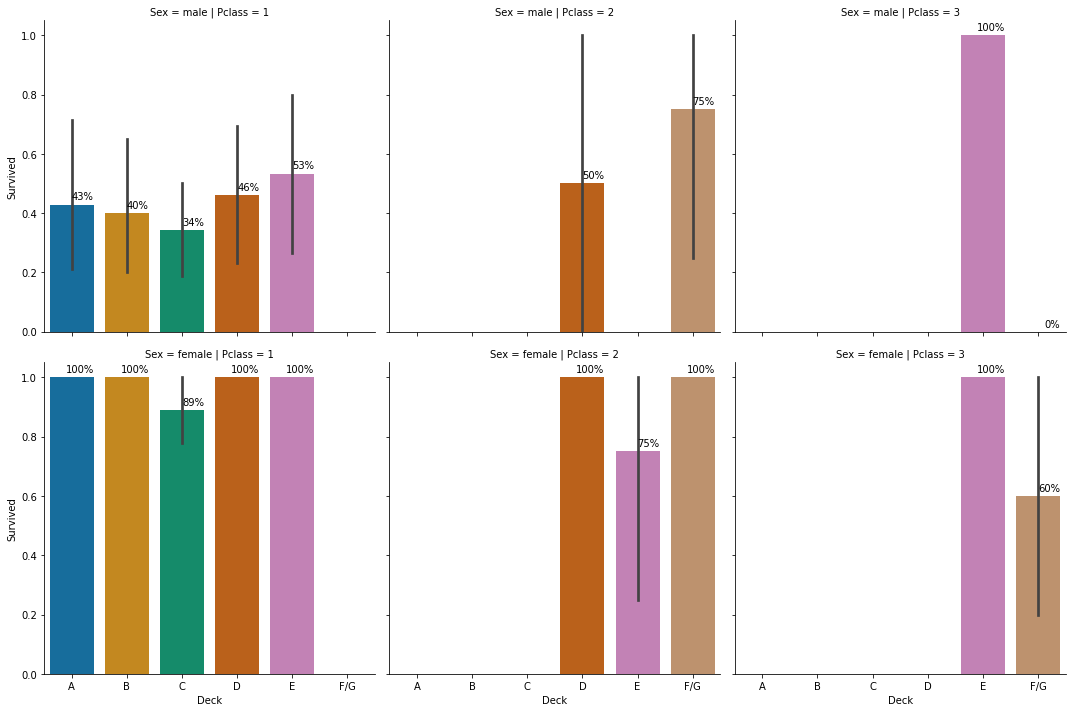

In [39]:
def get_deck(df):
    return df["Cabin"].str[0].replace({"F": "F/G", "G": "F/G", "T": np.nan})

g = sns.catplot(
    data=train.assign(Deck=get_deck(train)),
    x="Deck",
    y="Survived",
    col="Pclass",
    row="Sex",
    kind="bar",
    ci=95,
    order=["A", "B", "C", "D", "E", "F/G"],
)
for ax in g.axes.flat:
    add_rates(ax)

This isn't quite what would be expected, e.g. 100% survival rate for men in third class, however this could be an artefact of the level of record-keeping of the different passenger classes.

#### CabinNumber

Finally, cabin number could also be used to indicate where in the ship the cabin was (smaller cabin numbers are nearer the front of the ship), although it does not look like this will be that informative:

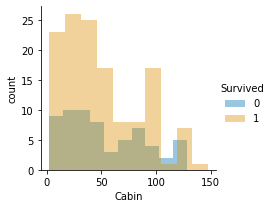

In [40]:
def get_cabin_number(df):
    return (
        df["Cabin"]
        .str.replace("[A-Z]", "")
        .str.split(" ")
        .str[0].replace("", np.nan)
        .astype(float)
    )

g = (
    sns.FacetGrid(train.assign(Cabin=get_cabin_number(train)), hue="Survived")
    .map(sns.distplot, "Cabin", kde=False, bins=10)
    .set_ylabels("count")
    .add_legend()
)

#### FamilySize

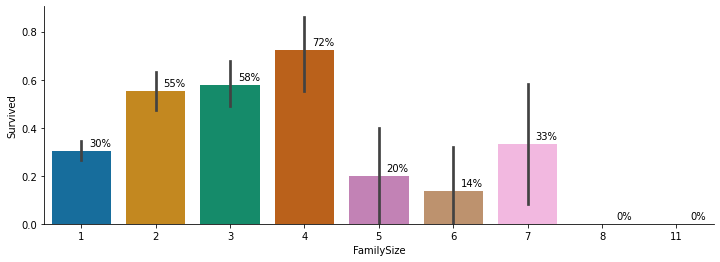

In [41]:
def get_family_size(df):
    return df["Parch"] + df["SibSp"] + 1

plt.figure(figsize=(12, 4))
ax = sns.barplot(
    data=train.assign(FamilySize=get_family_size(train)),
    x="FamilySize",
    y="Survived",
)
add_rates(ax)

#### FamilyCat

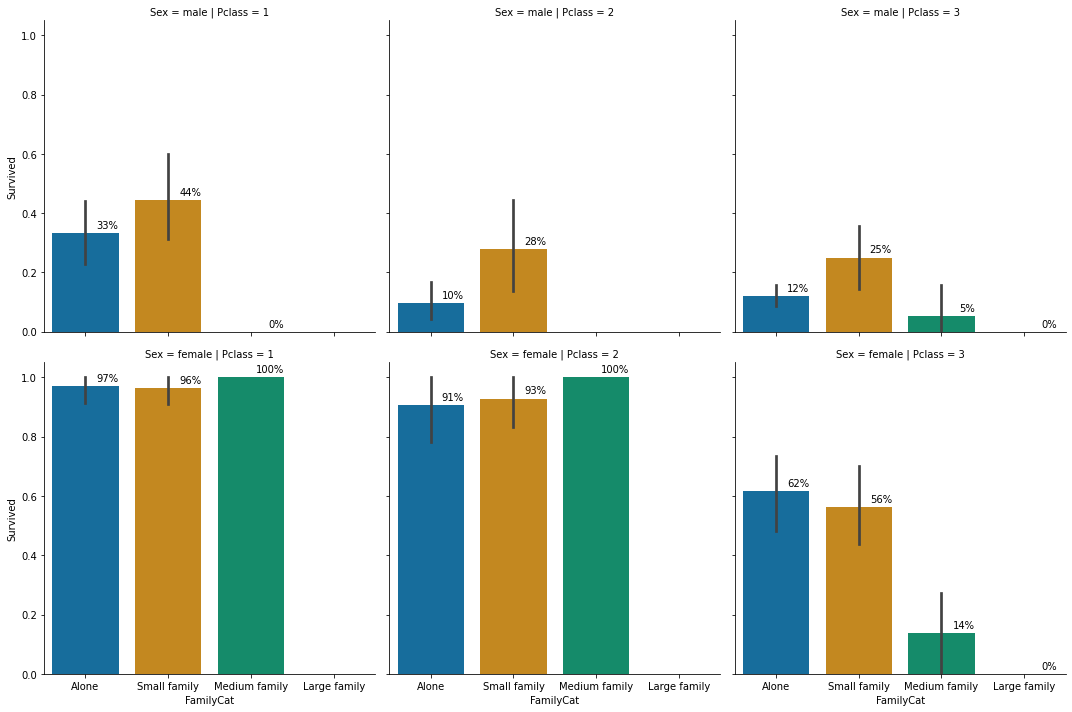

In [42]:
def get_family_category(df):
    return pd.cut(
        get_family_size(df),
        bins=[1, 2, 5, 8, 99],
        labels=["Alone", "Small family", "Medium family", "Large family"],
        right=False,
    )

g = sns.catplot(
    data=train.assign(FamilyCat=get_family_category(train)),
    x="FamilyCat",
    y="Survived",
    col="Pclass",
    row="Sex",
    kind="bar",
    ci=95,
    order=["Alone", "Small family", "Medium family", "Large family"],
)
for ax in g.axes.flat:
    add_rates(ax)

#### Title

The passenger's title can be extracted from their name, after the first comma and before the first full stop:

In [43]:
title = train["Name"].str.extract(r"^[^,]+, ([^.]+)\.")[0]
title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Mme               1
Don               1
Ms                1
Lady              1
the Countess      1
Jonkheer          1
Capt              1
Sir               1
Name: 0, dtype: int64

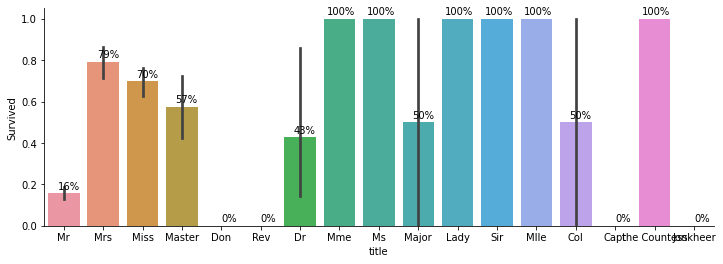

In [44]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    data=train.assign(title=title),
    x="title",
    y="Survived",
)
add_rates(ax)

Combining the smaller groups:

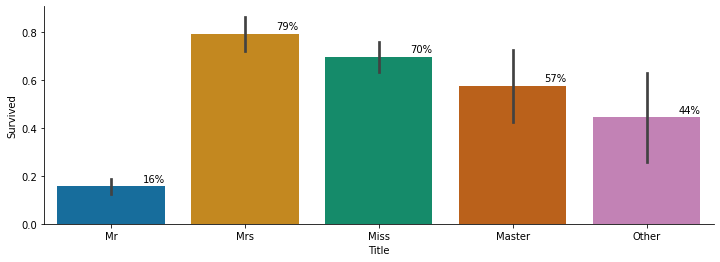

In [48]:
def get_title(df):
    title = df["Name"].str.extract(r"^[^,]+, ([^.]+)\.")[0]
    keep_titles = ["Mr", "Mrs", "Miss", "Master"]
    drop_titles = [t for t in title.unique() if t not in keep_titles]
    
    return (
        df["Name"]
        .str.extract(r"^[^,]+, ([^.]+)\.")[0]  # Get the title
        .replace({
            **{t: "Other" for t in drop_titles},
        })
    )

plt.figure(figsize=(12, 4))
ax = sns.barplot(
    data=train.assign(Title=get_title(train)),
    x="Title",
    y="Survived",
)
add_rates(ax)
plt.show()

#### Other

Other engineered features are also possible, e.g. using ticket number to establish a group size, which would also include domestic staff such as maids, cooks and drivers (that travelled along with their employer). Such analysis is not attempted here.

### Correlation and feature importance

Examine correlation between features and the target, first converting all the features of interest to numerical types, using some basic ordinal encodings:

In [73]:
def preprocess(data):
    # Create a copy of the data with engineered columns and transforms
    data = data.assign(
        Fare=transform_fare(data["Fare"]),
        AgeGroup=get_age_group(data),
        CabinNumber=get_cabin_number(data),
        Deck=get_deck(data),
        FamilyCat=get_family_category(data),
        FamilySize=get_family_size(data),
        MultiCabins=get_multiple_cabins(data),
        Title=get_title(data),
    )

    # Manually apply ordinal encoding
    data = data.replace({
        "Sex": {"male": 0, "female": 1},
        "Embarked": {"S": 0, "C": 1, "Q": 2},
        "AgeGroup": {"Child": 0, "Younger adult": 1, "Older adult": 0}, ###
        "Deck": {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F/G": 6},
        "FamilyCat": {"Alone": 0, "Small family": 1, "Medium family": 2, "Large family": 3},
        "MultiCabins": {"single": 0, "multiple": 1},
        "Title": {"Mr": 0, "Other": 1, "Master": 2, "Miss": 3, "Mrs": 4},
    }).drop([
        "Name",
        "Ticket",
        "Cabin",
    ], axis=1)

    return data
    
train_ = preprocess(train)
train_.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,CabinNumber,Deck,FamilyCat,FamilySize,MultiCabins,Title
PassengerId,,,,,,,,,,,,,,,
1,0,3,0,22.0,1,0,3.305054,0.0,1.0,NaN,NaN,1,2,NaN,0
2,1,1,1,38.0,1,0,4.513968,1.0,1.0,85.0,3.0,1,2,0.0,4
3,1,3,1,26.0,0,0,3.329522,0.0,1.0,NaN,NaN,0,1,NaN,3
4,1,1,1,35.0,1,0,4.291828,0.0,1.0,123.0,3.0,1,2,0.0,4
5,0,3,0,35.0,0,0,3.333989,0.0,1.0,NaN,NaN,0,1,NaN,0


Check the correlation of each feature to the target.

Suspect (based on the above exploratory data analysis) that some of the correlation won't be linear, so take both Pearson and Spearman rank.

In [50]:
corr = train_.corr()
ordered_features = corr["Survived"].abs().sort_values(ascending=False).index

print("Pearson ordered features")
corr["Survived"].loc[ordered_features]

Pearson ordered features


Survived       1.000000
Title          0.559697
Sex            0.543351
Pclass        -0.338481
Fare           0.321510
Embarked       0.108669
FamilyCat      0.083976
Parch          0.081629
AgeGroup      -0.079162
Age           -0.077221
CabinNumber   -0.054869
Deck           0.048245
SibSp         -0.035322
FamilySize     0.016639
MultiCabins   -0.011656
Name: Survived, dtype: float64

In [51]:
corr = train_.corr("spearman")
ordered_features = corr["Survived"].abs().sort_values(ascending=False).index

print("Spearman rank ordered features")
corr["Survived"].loc[ordered_features]

Spearman rank ordered features


Survived       1.000000
Title          0.560752
Sex            0.543351
Pclass        -0.339668
Fare           0.323736
FamilySize     0.165463
FamilyCat      0.159663
Parch          0.138266
Embarked       0.137869
SibSp          0.088879
AgeGroup      -0.079162
CabinNumber   -0.057643
Age           -0.052565
Deck           0.047774
MultiCabins   -0.011656
Name: Survived, dtype: float64

Initial findings:

* Title, Sex, Pclass and Fare show the highest correlation in both cases, although it is likely Pclass and Fare are highly correlated to each other (see below). Embarked is also slightly correlated with survival rate.
* Age (or AgeGroup) and FamilySize (or FamilyCat, Parch or SibSp) do not show strong correlation according to these metrics, however the exploratory data analysis showed they were correlated to survival rate when other features were taken into account. Therefore these features should add value, especailly in a non-linear model like a tree.
* CabinNumber, Deck and MultiCabins do not seem well correlated to the survival rate.

Another way of estimating the usefulness of features is to quickly fit a tree-based model (e.g. a random forest model), then look at the feature importances (although note that some features are correlated, so this won't be a completely accurate picture).

In [98]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100)

X = train_.drop(columns="Survived").fillna(0)  # Just fill NaNs with 0 at this stage
y = train_["Survived"]
classifier.fit(X[:700], y[:700])

pd.Series(classifier.feature_importances_, index=X.columns).sort_values(ascending=False)

Fare           0.208933
Title          0.178909
Age            0.176274
Sex            0.126207
Pclass         0.057254
CabinNumber    0.052084
FamilySize     0.040470
Deck           0.036118
Embarked       0.030109
FamilyCat      0.028244
SibSp          0.022869
AgeGroup       0.020632
Parch          0.017180
MultiCabins    0.004716
dtype: float64

Further findings:

* As before - Fare, Title, Sex and Pclass are useful predictors of the target.
* However - Age also shows up highly on this list (as expected for a tree-based model). CabinNumber, FamilySize and Deck now also seem reasonably important.
* Embarked now appears to be less important, and as before MultiCabins does not seem useful in predicting the target.

To understand the correlation betwen features themselves, the correlation matrix can be visualised as a heatmap.

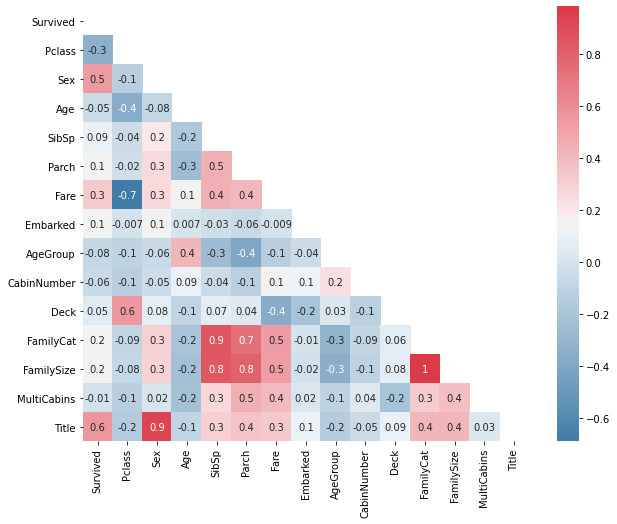

In [52]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    mask=np.triu(np.ones_like(corr)),
    cmap=sns.diverging_palette(240, 10, as_cmap=True),
    annot=True,
    fmt="0.1g",
)

Findings:

* All of the derived features are highly correlated to their parent features, as would be expected. As are Title and Sex. Fare and Pclass are also highly correlated, as discussed above.
* FamilySize (or FamilyCat) and Age (or AgeGroup) show some correlation, which makes sense. As do FamilySize and MultiCabins, and Deck and Fare.

Some models perform poorly with highly-correlated features, so a dimensionality reduction technique such as PCA may be beneficial.

Another way to visualise the correlation is to perform hierarchical clustering on the Spearman rank-order correlations:

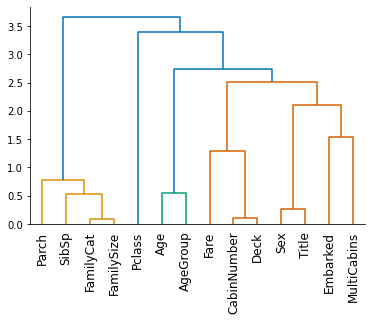

In [112]:
from scipy.cluster import hierarchy

corr = X.corr("spearman")
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=X.columns, leaf_rotation=90)

Taking a arbitrary distance of 2 on the y-axis, there are 6 clusters of features. These are approximately groupings containing the prevously-identified useful (or unuseful) features:

Clusters containing a useful feature (or features):
* Pclass
* Age (and related AgeGroup)
* Fare (and CabinNumber, Deck)
* Sex and Title

Clusters of less useful features:
* FamilySize (and related features)
* Embarked and MultiCabins

Taking account of all the above, it is suggested the following features are used for modelling:

1. Pclass
2. Age or AgeGroup
3. Fare
4. Sex
5. Title (although this is correlated with Sex)
6. FamilySize or FamilyCat
7. Embarked

## Model the data

Summary of modelling steps:

1. Train/test split
    * How should the training data be split into train/validation/test
    * Should the data be shuffled/stratified?


2. Expectations
    * What is the baseline score? (the model should do better than this)
    * Is it possible to devise a simple expert system? (could be naively used to give coefficients or feature importances)
    * What models are available for this problem?


3. Initial training
    * Choose initial hyperparameter values for each model for a quick comparison
    * Score each model
    * What model considerations are there? e.g.
        - execution time
        - ease of tuning
        - stability
    * What are the feature importances?
        - should some be removed?
        - should deminsionality be reduced?
    * What types of errors do the models make?
    * Shortlist promising models


4. Fine-tuning
    * How will hyperparameters be tuned? e.g.
        - Exhaustive grid search
        - Random grid search
        - Other methods
    * How will model performance be visualised and debugged?
    * Bias/variance trade-off
        - can use learning curves
        - would more training data or extra features improve the model?
        - has a plataeu been reached?
    * Could a stacked ensemble model be used to further improve performance?
    * Check generalisation error on the test set

### Set aside test set in the training data

Although Kaggle provided a test set, this is evaluated on their servers, so set aside another modest test set to estimate generalisation error before submitting to Kaggle. Also set aside some validation data for cases where cross-validation is not used. Before submissions, the model can be re-trained on all the training data.

In [249]:
from sklearn.model_selection import train_test_split

X = train.drop(columns="Survived")
y = train["Survived"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=1234)

### Baseline scores

62% of passengers died, so could predict every passenger died and get a model with on average 62% accuracy. Therefore any other model should do better than this.

In [250]:
from sklearn.dummy import DummyClassifier

classifier = DummyClassifier(strategy="most_frequent")
classifier.fit(X_train, y_train)
classifier.score(X_val, y_val)

0.6149068322981367

A better attempt is to train a logistic regression model using the top three features identified above: Title, Sex and Pclass:

In [251]:
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from utils import AddFeature

add_features = make_pipeline(
    AddFeature("Title", get_title),
)

select_transform_columns = make_column_transformer(
    (OrdinalEncoder(categories=[
        ["Mr", "Other", "Master", "Miss", "Mrs"],
        ["male", "female"],
    ]), ["Title", "Sex"]),
    ("passthrough", ["Pclass"]),
)

pipeline = make_pipeline(
    add_features,
    select_transform_columns,
    LogisticRegression(),
)

cv = cross_validate(pipeline, X_train_full, y_train_full, cv=5)
cv["test_score"].mean()

0.7865217391304348

This models scores 79%, which is a big improvement on the dummy classifier. The final model should be getting a score higher than this, to be worth bothering with.

### Initial comparison of models

Models to be evaluated are:

* Logistic regression
* Support vector machines
    - Linear SVC
    - SVC (polynomial kernel and rbf kernel)
* Decision trees
* Nearest neighbours
    - k-nearest neighbours vote
* Neural network
    - Simple multi-layer perceptron
* Ensemble methods
    - Random forest classifier
    - Gradient boosting classifier
    - AdaBoost
    - XGBoost

Original features to be considered are:
* Pclass
* Sex (with ordinal encoding)
* Fare (with log transform)
* Embarked (with one-hot encoding)

Engineered features to be considered are:
* AgeGroup (with one-hot encoding)
* FamilyCat (with one-hot encoding)
* Title (with ordinal encoding)

Ordinal encodings are used where there was a clear ordering to the categories and survival rate. One-hot encodings are used where this was less clear.

There are some missing values, predominantly in the AgeGroup feature, although these are not that numerous, so impute but choosing the most frequent category.

In [252]:
from sklearn.compose import make_column_selector
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

add_features = make_pipeline(
    AddFeature("AgeGroup", get_age_group),
    AddFeature("FamilyCat", get_family_category),
    AddFeature("Title", get_title),
)

ordinal_encodings = [
    ("Title", ["Mr", "Other", "Master", "Miss", "Mrs"]),
    ("Sex", ["male", "female"]),
]
ordinal_columns, ordinal_categories = zip(*ordinal_encodings)
ordinal_encoder = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordinal_categories)
)

onehot_columns = [
    "Embarked",
    "AgeGroup",
    "FamilyCat",
]
onehot_encoder = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(),
)

fare_transformer = make_pipeline(
    FunctionTransformer(transform_fare),
    SimpleImputer(strategy="median"),
)

select_transform_columns = make_column_transformer(
    (ordinal_encoder, ordinal_columns),
    (onehot_encoder, onehot_columns),
    (fare_transformer, ["Fare"]),
    (SimpleImputer(strategy="most_frequent"), ["Pclass"]),
)

dimensionality_reduction = PCA(n_components=7)

pipeline = Pipeline([
    ("add_features", add_features),
    ("select_transform", select_transform_columns),
    ("dim_reduction", dimensionality_reduction),
    ("classifier", LogisticRegression()),
])

Run a stratified cross-validation search using each of the candidate classifiers:

In [253]:
from sklearn.model_selection import GridSearchCV
#from sklego.pipeline import DebugPipeline

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

grid_search = GridSearchCV(
    pipeline,
    #DebugPipeline(pipeline.steps, log_callback='default'),
    {
        "classifier": [
            LogisticRegression(),
            LinearSVC(loss="hinge", max_iter=1e5, random_state=1234),
            SVC(kernel="poly", degree=5, random_state=1234),
            SVC(kernel="rbf", random_state=1234),
            DecisionTreeClassifier(max_depth=10, random_state=1234),
            KNeighborsClassifier(),
            MLPClassifier(hidden_layer_sizes=(20, 20, 20), solver="sgd", learning_rate_init=0.1, max_iter=20, random_state=1234),
            RandomForestClassifier(n_estimators=500, max_depth=5, random_state=1234),
            GradientBoostingClassifier(random_state=1234),
            AdaBoostClassifier(random_state=1234),
            XGBClassifier(random_state=1234),
        ],
    },
    cv=5,
    verbose=1,
)

In [254]:
# Do the grid search using all available cores
from joblib import parallel_backend
with parallel_backend("threading", n_jobs=-1):
    grid_search.fit(X_train_full, y_train_full)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) rea

Return the mean scores in order (with standard deviation to give an indication of the stability of the model):

In [255]:
results = pd.DataFrame({
    "Classifier": [params["classifier"] for params in grid_search.cv_results_["params"]],
    "Mean CV score": grid_search.cv_results_["mean_test_score"],
    "Std CV score": grid_search.cv_results_["std_test_score"],
    "Train time": grid_search.cv_results_["mean_fit_time"],
    "Predict time": grid_search.cv_results_["mean_score_time"],
    
}).sort_values("Mean CV score", ascending=False).reset_index(drop=True)

results

,Classifier,Mean CV score,Std CV score,Train time,Predict time
0,"RandomForestClassifier(max_depth=5, n_estimators=500, random_state=1234)",0.830225,0.018994,30.578735,0.712374
1,KNeighborsClassifier(),0.826483,0.018116,1.272767,1.224338
2,"MLPClassifier(hidden_layer_sizes=(20, 20, 20), learning_rate_init=0.1,\n max_iter=20, random_state=1234, solver='sgd')",0.820241,0.022005,7.310506,0.462887
3,SVC(random_state=1234),0.819014,0.018098,1.564233,0.470615
4,GradientBoostingClassifier(random_state=1234),0.818998,0.026931,8.842531,0.139894
5,AdaBoostClassifier(random_state=1234),0.812741,0.007728,3.175514,0.289473
6,"LinearSVC(loss='hinge', max_iter=100000.0, random_state=1234)",0.807741,0.008269,1.455766,0.427603
7,LogisticRegression(),0.806522,0.026265,1.449457,0.379718
8,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n random_state=1234, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",0.802772,0.026184,2.360001,0.114777
9,"DecisionTreeClassifier(max_depth=10, random_state=1234)",0.797803,0.027393,1.588324,0.502410


The top five performing models are:
1. Random forest classifer
2. K-nearest neighbour classifier
3. Simple neural network
4. Support vector machine with rbf kernel
5. Gradient boosting classifer

Stability:
* The gradient boosting classifier seems the least stable across the cross-validation.
* The logistic regression classifier also sometimes performs performs well, but its scores are also less stable, and with this particular  train-test split it scores less well.

Train time:
* The random forest classifier is the slowest to train.
* The neural network can also take a long time to train. but this is heavily dependent on the complexity of the hidden layers.

Predict time:
* The k-nearest neighbour and random forest classifiers are the slowest to use.

#### Learning curves

It is possible that the neural network may not generalise will, because it is likely to overfit on a dataset this small.

Can check for overfitting by plotting a learning curve of accuracy against number of training data points.

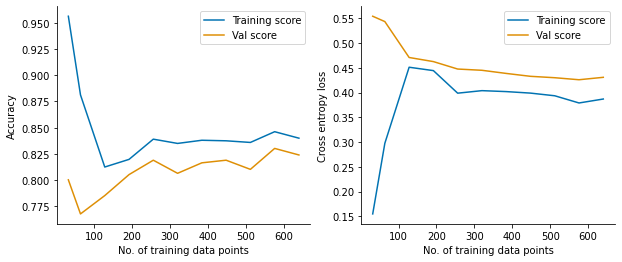

In [264]:
import warnings
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve

preprocess = Pipeline(pipeline.steps[:-1])
classifier = MLPClassifier(
    hidden_layer_sizes=(20, 20, 20),
    solver="sgd",
    learning_rate_init=0.1,
    max_iter=20,
    warm_start=False,
    random_state=1234,
)

X_train_full_transformed = preprocess.fit_transform(X_train_full)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    n_train, train_score, val_score = learning_curve(
        classifier,
        X_train_full_transformed,
        y_train_full,
        train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        cv=5,
        random_state=1234,
    )

plt.figure(figsize=(10, 4))
    
plt.subplot(121)
plt.plot(n_train, train_score.mean(axis=1), label="Training score")
plt.plot(n_train, val_score.mean(axis=1), label="Val score")
plt.xlabel("No. of training data points")
plt.ylabel("Accuracy")
plt.legend()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    n_train, train_score, val_score = learning_curve(
        classifier,
        X_train_full_transformed,
        y_train_full,
        scoring="neg_log_loss",
        train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        cv=5,
        random_state=1234,
    )

plt.subplot(122)
plt.plot(n_train, -train_score.mean(axis=1), label="Training score")
plt.plot(n_train, -val_score.mean(axis=1), label="Val score")
plt.xlabel("No. of training data points")
plt.ylabel("Cross entropy loss")
plt.legend()

Despite concerns, the model does not appear to badly overfit. The training and validation lines are relatively close together, indicating a there are a sufficient number of training data points.

#### Loss curves

Neural network training is slower than the other models.

Plot the accuracy and loss curves against training epoch to determine a maximum number of epochs to consider (although early stopping should help prevent superfluous training and overfitting).

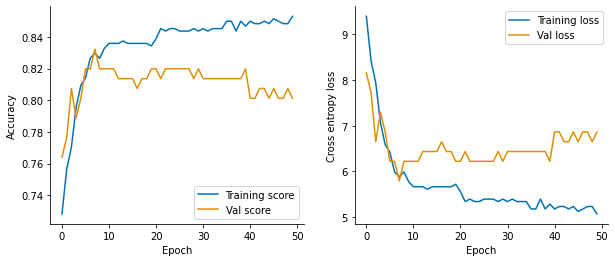

In [257]:
from sklearn.metrics import accuracy_score, log_loss

classifier = MLPClassifier(
    hidden_layer_sizes=(20, 20, 20),
    solver="sgd",
    learning_rate_init=0.1,
    max_iter=1,
    warm_start=True,
    random_state=1234,
)

X_train_transformed = preprocess.fit_transform(X_train)
X_val_transformed = preprocess.fit_transform(X_val)

epochs = 50
train_score = []
train_loss = []
val_score = []
val_loss = []
for _ in range(epochs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        classifier.fit(X_train_transformed, y_train)
    
    y_hat = classifier.predict(X_train_transformed)
    train_score.append(accuracy_score(y_train, y_hat))
    train_loss.append(log_loss(y_train, y_hat))
    
    y_hat = classifier.predict(X_val_transformed)
    val_score.append(accuracy_score(y_val, y_hat))
    val_loss.append(log_loss(y_val, y_hat))

plt.figure(figsize=(10, 4))
    
plt.subplot(121)
plt.plot(train_score, label="Training score")
plt.plot(val_score, label="Val score")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(122)
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.legend()

Training will be limited to 10 epochs, as there is no gain (and a slightl drop in performance) beyond this point.

### Fine-tuning shortlisted models

Shortlisted models:
* Random forest classifer
* Support vector machine with rbf kernel
* Gradient boosting classifer
* Logistic regression

The above simple neural network will also be used, however to reduce execution time the parameters will not be tuned further.

In [267]:
from sklearn.linear_model import LogisticRegressionCV

random_forest = {
    "classifier": [RandomForestClassifier(random_state=1234)],
    "classifier__n_estimators": [100, 500, 1000],
    "classifier__max_depth": [2, 3, 4, 5],
}

svm = {
    "classifier": [SVC(kernel="rbf", random_state=1234)],
    "classifier__C": [0.1, 1.0, 10.0, 100.0],
    "classifier__class_weight": [None, "balanced"],
}

gradient_boosting = {
    "classifier": [GradientBoostingClassifier(random_state=1234)],
    "classifier__learning_rate": [0.001, 0.01, 0.1],
    "classifier__n_estimators": [100, 500, 1000],
}

logistic_regression = {
    # Logistic regression implements its own grid search for C with CV
    "classifier": [LogisticRegressionCV(Cs=10, cv=5, random_state=1234)],
    "classifier__class_weight": [None, "balanced"],
}

neural_network = {
    # Do no tune neural network further
    "classifier": [MLPClassifier(hidden_layer_sizes=(20, 20, 20), solver="sgd", learning_rate_init=0.1, max_iter=10, random_state=1234)],
}

grid_search = GridSearchCV(
    pipeline,
    [
        random_forest,
        svm,
        gradient_boosting,
        logistic_regression,
        neural_network,
    ],
    cv=5,
    verbose=1,
)

with parallel_backend("threading", n_jobs=-1):
    grid_search.fit(X_train_full, y_train_full)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: Converg

In [268]:
from operator import itemgetter
from sklearn.base import clone

def ordered_results(grid_search):
    num_estimators = len(grid_search.cv_results_["rank_test_score"])
    results = [{name: value[i] for name, value in grid_search.cv_results_.items()} for i in range(num_estimators)]
    return list(sorted(results, key=itemgetter("rank_test_score")))

def get_estimator(grid_search, result):
    estimator = clone(grid_search.estimator)
    estimator.set_params(**result["params"])
    return estimator

def print_results(grid_search):
    results = ordered_results(grid_search)
    
    for result in results:
        estimator = get_estimator(grid_search, result)
        print(f"{result['rank_test_score']}. {estimator.named_steps['classifier']}")
        print(f"    CV score = {result['mean_test_score']:0.4f} ± {result['std_test_score']:0.4f}")
        print(f"    Timings  = {result['mean_fit_time']:0.3f} (training), {result['mean_score_time']:0.3f} (predict)")
        print()
        
print_results(grid_search)

1. RandomForestClassifier(max_depth=4, n_estimators=500, random_state=1234)
    CV score = 0.8365 ± 0.0202
    Timings  = 32.439 (training), 1.490 (predict)

2. RandomForestClassifier(max_depth=4, n_estimators=1000, random_state=1234)
    CV score = 0.8365 ± 0.0228
    Timings  = 61.948 (training), 3.080 (predict)

3. RandomForestClassifier(max_depth=4, random_state=1234)
    CV score = 0.8365 ± 0.0199
    Timings  = 7.167 (training), 0.360 (predict)

4. RandomForestClassifier(max_depth=5, random_state=1234)
    CV score = 0.8327 ± 0.0202
    Timings  = 7.159 (training), 0.338 (predict)

5. RandomForestClassifier(max_depth=5, n_estimators=500, random_state=1234)
    CV score = 0.8302 ± 0.0190
    Timings  = 35.833 (training), 1.857 (predict)

6. RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=1234)
    CV score = 0.8290 ± 0.0210
    Timings  = 65.260 (training), 2.263 (predict)

7. SVC(C=10.0, random_state=1234)
    CV score = 0.8265 ± 0.0232
    Timings  = 0.701 (t

The top parameters for each model are:

In [279]:
from sklearn.base import clone

# random_forest = clone(pipeline).set_params(classifier=RandomForestClassifier(max_depth=3, n_estimators=500, random_state=1234))
random_forest = clone(pipeline).set_params(classifier=RandomForestClassifier(max_depth=4, n_estimators=500, random_state=1234))

# svm = clone(pipeline).set_params(classifier=SVC(C=1.0, class_weight=None, random_state=1234, probability=True))
svm = clone(pipeline).set_params(classifier=SVC(C=10.0, class_weight=None, random_state=1234, probability=True))

gradient_boosting = clone(pipeline).set_params(classifier=GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, random_state=1234))

logistic_regression = clone(pipeline).set_params(classifier=LogisticRegressionCV(class_weight=None, Cs=10, cv=5, random_state=1234))

neural_network = clone(pipeline).set_params(classifier=MLPClassifier(hidden_layer_sizes=(20, 20, 20), solver="sgd", learning_rate_init=0.1, max_iter=10, random_state=1234))

### Errors analysis

Look at the errors that the top models make:

In [272]:
results = ordered_results(grid_search)
results = [results[0]] + [results[6]] + [results[7]] + [results[12]]

for result in results:
    estimator = get_estimator(grid_search, result)
    estimator.fit(X_train, y_train)
    correct_result = (estimator.predict(X_val) == y_val)
    errors_debug = X_val.assign(CorrectResult=correct_result, AgeGroup=get_age_group(X_val))
    
    print(estimator.named_steps["classifier"])
    print(errors_debug.groupby(["Pclass", "Sex", "AgeGroup"])["CorrectResult"].mean())
    print()

RandomForestClassifier(max_depth=4, n_estimators=500, random_state=1234)
Pclass  Sex     AgeGroup     
1       female  Child                 NaN
                Younger adult    1.000000
                Older adult           NaN
        male    Child            1.000000
                Younger adult    0.615385
                Older adult           NaN
2       female  Child            1.000000
                Younger adult    1.000000
                Older adult           NaN
        male    Child            1.000000
                Younger adult    0.937500
                Older adult           NaN
3       female  Child            1.000000
                Younger adult    0.600000
                Older adult           NaN
        male    Child            1.000000
                Younger adult    0.853659
                Older adult           NaN
Name: CorrectResult, dtype: float64

SVC(C=10.0, random_state=1234)
Pclass  Sex     AgeGroup     
1       female  Child                 NaN
 

/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Most models seem to make errors in the 1st class younger adult male group and the 3rd class younder female groups.

### Ensemble methods

Ideally each model would independently make errors across the different groups, and we could use a voting classifier to get the best overall answer. It's unlike that this independence is satisfied here, however a voting classifier will proably still help a bit.

All of the models are able to return a probability for each class, so as an added bonus a soft-voting classifier can be used, which is likely to produce slightly better results.

In [281]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(estimators=(
    ("random_forest", random_forest),
    ("svm", svm),
    ("gradient_boosting", gradient_boosting),
    ("logistic_regression", logistic_regression),
    ("neural_network", neural_network),
), voting="soft")

cv = cross_validate(voting_classifier, X_train_full, y_train_full, cv=5)
cv["test_score"].mean()

/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/.vir

0.8289829192546584

The cross validation score of the ensemble method (a voting classifier) is 0.829. Although this is slightly less than the individual random forest model, it is lkely to generalise better.

In [282]:
voting_classifier.fit(X_train_full, y_train_full)
voting_classifier.score(X_test, y_test)

/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8333333333333334

An estimate of the generalisation score of the model is 0.833.

## Retrain and submit results

The model can now be retrained on all the training data and uses to predict on the Kaggle test set.

In [283]:
voting_classifier.fit(X, y)
y_pred = voting_classifier.predict(test)
submission = pd.Series(y_pred, index=test.index, name="Survived")
submission.to_csv("../processed_data/submission.csv")

/home/james/.virtualenvs/data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [285]:
!kaggle competitions submit -f "../processed_data/submission.csv" -m "Voting classifier submission" titanic 

100%|██████████████████████████████████████| 2.77k/2.77k [00:02<00:00, 1.38kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster

This models scores `0.79186` on the Kaggle test set, which is a bit lower than the predicted generalisation score. The is probably because the statistics of the Kaggle test set are not quite the same as the statistics of the training set, etc.

In [322]:
my_score = 0.79186
leaderboard = pd.read_csv("../raw_data/titanic-publicleaderboard.csv")

total_submissions = leaderboard["Score"].count()
less_than_mine = (leaderboard["Score"] < my_score).sum()
equal_to_mine = (leaderboard["Score"] == my_score).sum()
more_than_mine = (leaderboard["Score"] > my_score).sum()

print("Number of Kaggle submissions:")
print(f"Less than my score = {less_than_mine:5}")
print(f"Equal to my score  = {equal_to_mine:5}")
print(f"More than my score = {more_than_mine:5}")
print(f"TOTAL              = {total_submissions:5}")

quantile = (less_than_mine + equal_to_mine/2) / total_submissions

print()
print(f"Average percentile = {quantile:0.1%}")

Number of Kaggle submissions:
Less than my score = 38331
Equal to my score  =   364
More than my score =  3473
TOTAL              = 42168

Average percentile = 91.3%


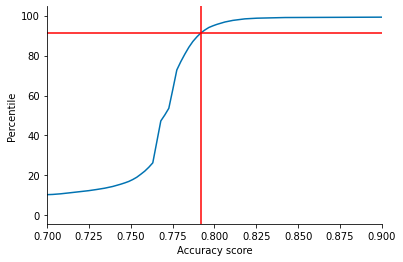

In [324]:
scores = leaderboard["Score"].sort_values()
rank = scores.rank(pct=True)
plt.plot(scores, rank * 100)
plt.xlabel("Accuracy score")
plt.ylabel("Percentile")
plt.axvline(my_score, color="r")
plt.axhline(quantile * 100, color="r")
plt.xlim(0.7, 0.9);

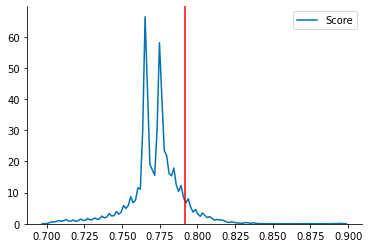

In [328]:
sns.kdeplot(scores, clip=(0.7, 0.9))
plt.axvline(my_score, color="r");

## Optional extras

Other work that could be conducted includes:

* Plotting a ROC curve
* Taking various hyperparameters and plot on a graph showing accuracy or cross entropy loss on training and validation sets
    - Independently at first
    - Then could try on a heatmap or parallel coordinates plot
* Plot more learning curves for chosen models